### **Import Necessary Libraries:**

In [2]:
import numpy as np
import pandas as pd
import glob
import math
import os
import torch
import random
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

home = '/home/ubuntu/'
 
# import geffnet

In [3]:
!pip install -q kaggle
# Create a directory where API key will be stored
!mkdir -p ~/.kaggle
# Move the API key to where Kaggle expects it to be
!cp /content/kaggle.json ~/.kaggle/
# Give according rights to the file
!chmod 600 /root/.kaggle/kaggle.json
# Finally, download the dataset (.zip file)
!kaggle datasets download -d saurabhshahane/phishiris
# Unzip the data 


 99% 756M/762M [00:18<00:00, 43.5MB/s]
100% 762M/762M [00:19<00:00, 42.0MB/s]


In [4]:
!cp /content/phishiris.zip /content/gdrive/MyDrive/Spam/phishiris.zip

In [2]:
!unzip -qq phishiris.zip -d /content/


In [7]:
classes = os.listdir(home+"FIGA/Image Spam Detector/phishIRIS_DL_Dataset/phishIRIS_DL_Dataset/train")
for direc in classes:
  files = glob.glob(home+'FIGA/Image Spam Detector/phishIRIS_DL_Dataset/phishIRIS_DL_Dataset/train/'+direc+'/*')
  for file in files:
    os.rename(file, file.replace(direc+'/',''))
  os.rmdir(home+"FIGA/Image Spam Detector/phishIRIS_DL_Dataset/phishIRIS_DL_Dataset/train/"+direc)

In [ ]:
!rmdir $home/FIGA/Image\ Spam\ Detector/phishIRIS_DL_Dataset/train/.ipynb_checkpoints
!rmdir $home/FIGA/Image\ Spam\ Detector/phishIRIS_DL_Dataset/val/.ipynb_checkpoints
!rmdir $home/FIGA/Image\ Spam\ Detector/phishIRIS_DL_Dataset/.ipynb_checkpoints

## **Load The Data**

In [40]:
data_dir = home+'FIGA/Image Spam Detector/phishIRIS_DL_Dataset'
random.seed(41)

#Data Tranforms (Augmentation and Normalization)
train_transforms = transforms.Compose([
                                       transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

#Getting all the data with PyTorch Datasets
train_data = datasets.ImageFolder(data_dir + '/train', transform= train_transforms)
val_data = datasets.ImageFolder(data_dir + '/val', transform= test_transforms)

#Loading the data into PyTorch DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size= 64, shuffle = True,num_workers=2)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size= 64, shuffle = True,num_workers=2)

#Creating a dictionary of all classes
classes = dict(zip(list(range(len(train_data.classes))),train_data.classes))

In [39]:
classes

{0: 'Ham', 1: 'Spam'}

### **Check the images with labels**

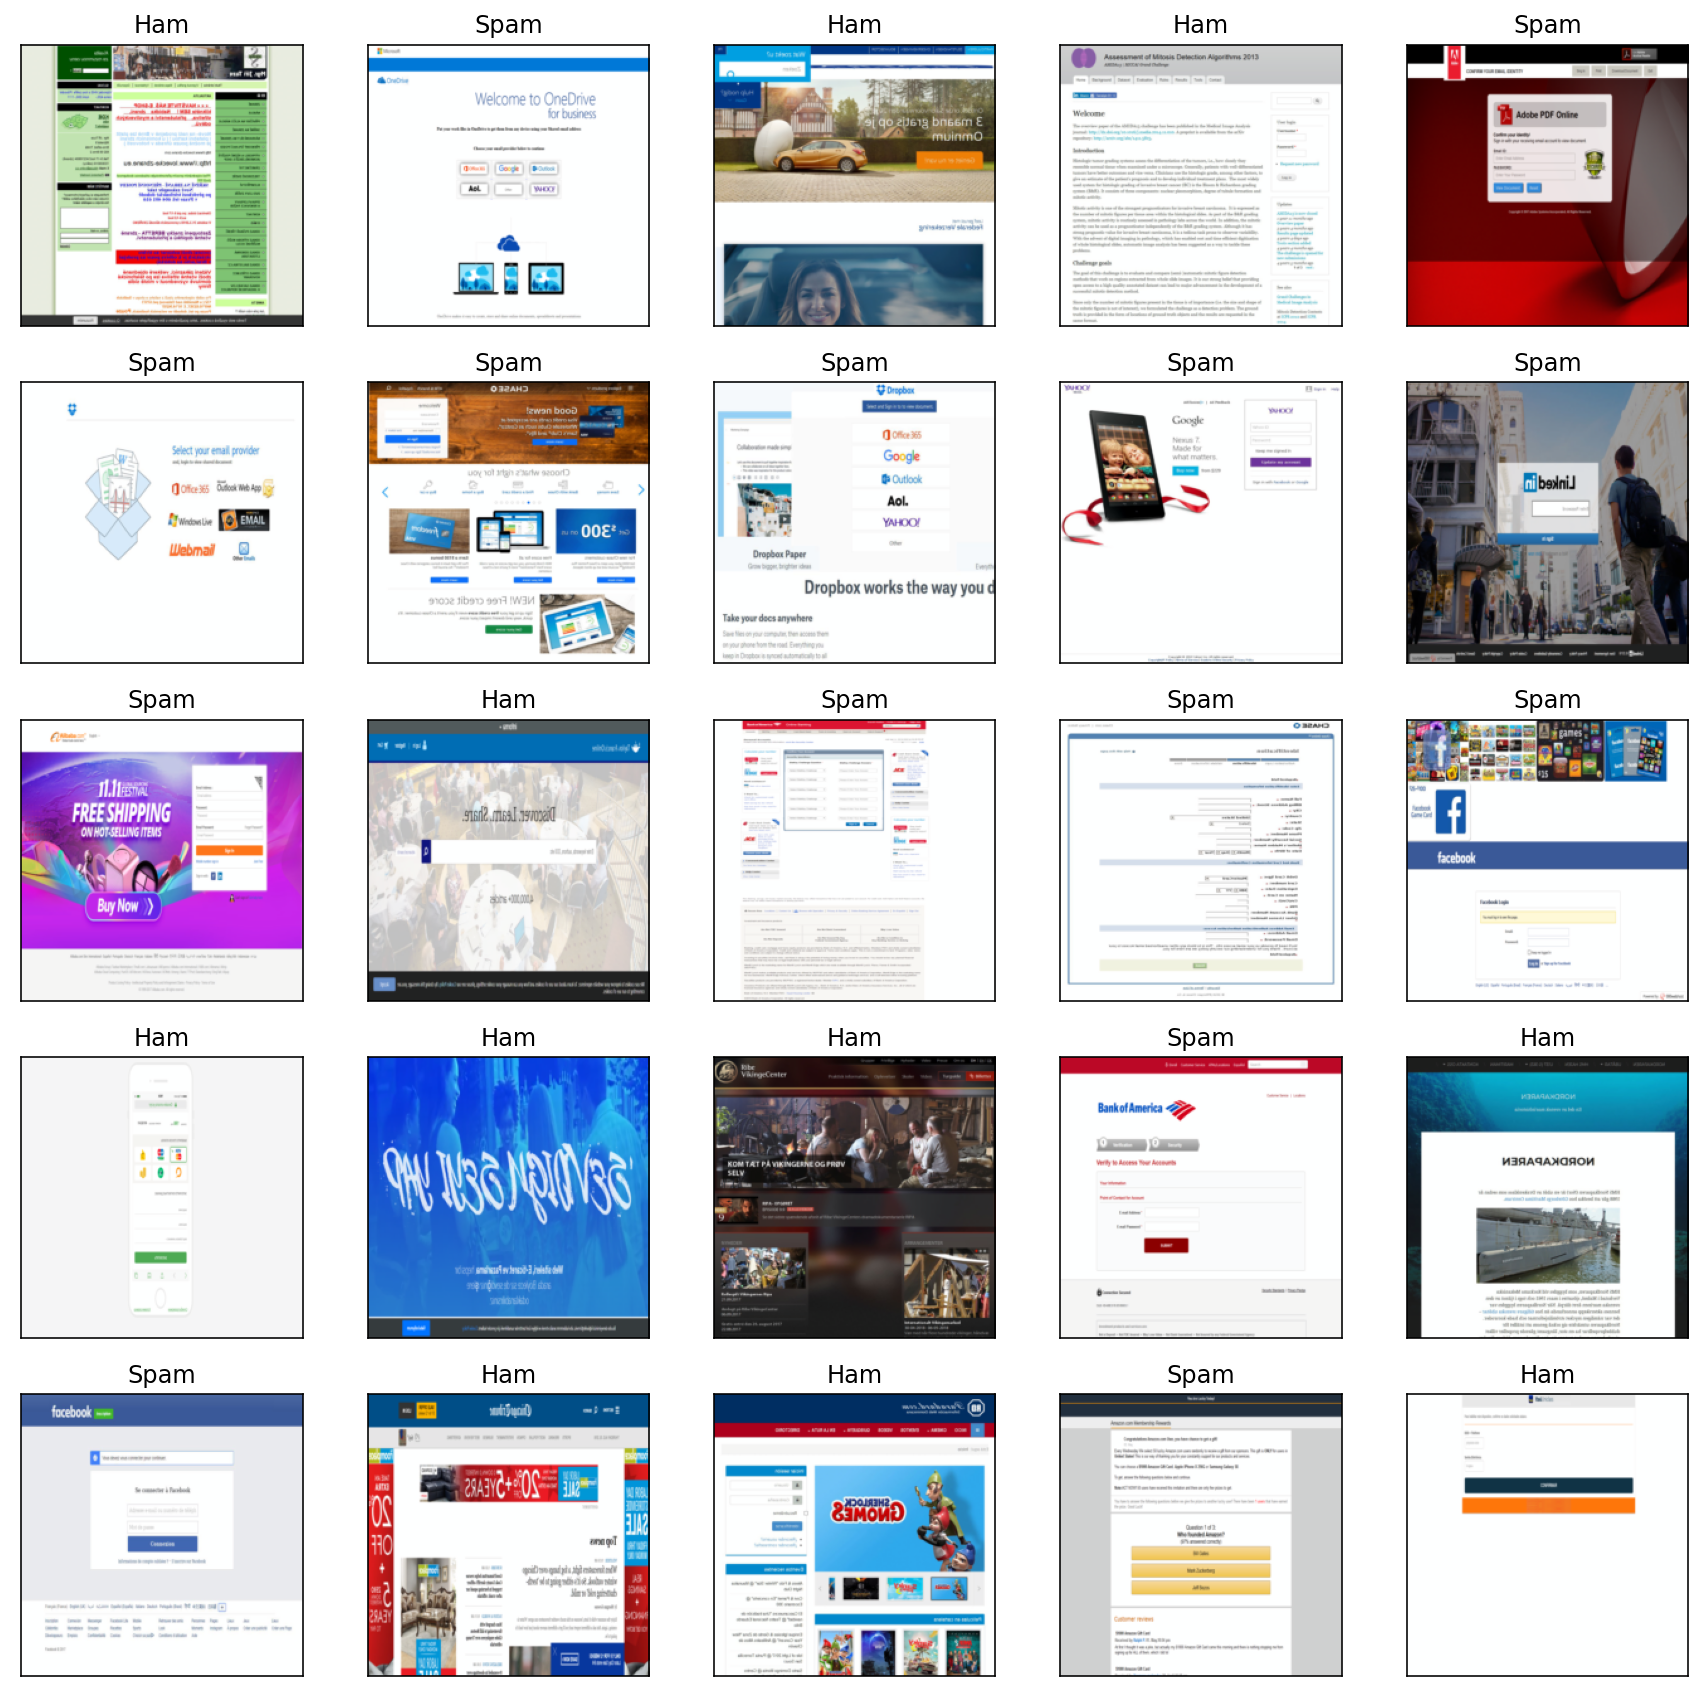

In [17]:
def denormalise(image):
  try:
    image = image.cpu().numpy().transpose(1, 2, 0)
  except:
    image = image.transpose(1, 2, 0) # PIL images have channel last
  mean = [0.485, 0.456, 0.406]
  stdd = [0.229, 0.224, 0.225]
  image = (image * stdd + mean).clip(0, 1)
  return image

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(15,15))

for idx in np.arange(25):
  ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
  ax.imshow(denormalise(images[idx]), cmap='gray')
  ax.set_title(classes[labels[idx].item()])

## **Load the model**

In [3]:
# Specify the device type
device = torch.device('hpu')
device

device(type='hpu')

In [42]:
# Loading the model
model = models.efficientnet_b4(pretrained=True)

# Freezing all the layers
for param in model.parameters():
  param.requires_grad = False

# Changing the Classifier
model.classifier = nn.Sequential(nn.Linear(1792,896),
                           nn.ReLU(),
                           nn.Dropout(p=0.4),
                           nn.Linear(896,448),
                           nn.ReLU(),
                           nn.Dropout(p=0.4),
                           nn.Linear(448,112),
                           nn.ReLU(),
                           nn.Dropout(p=0.4),
                           nn.Linear(112,len(classes)))

# Making the Classifier layer Trainable                           
for param in model.classifier.parameters():
  param.requires_grad = True

# Moving the model to device
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(

### **Specify the Loss Criterion, Optimizer and Scheduler**

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.classifier.parameters(),lr = 0.01)
scheduler = StepLR(optimizer, step_size=2, gamma=0.35)

In [ ]:
from habana_frameworks.torch.utils.library_loader import load_habana_module
import habana_frameworks.torch.core as htcore
load_habana_module()
def permute_params(model, to_filters_last, lazy_mode):
    import habana_frameworks.torch.core as htcore
    if htcore.is_enabled_weight_permute_pass() is True:
        return
    with torch.no_grad():
        for name, param in model.named_parameters():
            if(param.ndim == 4):
                if to_filters_last:
                    param.data = param.data.permute((2, 3, 1, 0))
                else:
                    param.data = param.data.permute((3, 2, 0, 1))  # permute RSCK to KCRS
    if lazy_mode:
        import habana_frameworks.torch.core as htcore
        htcore.mark_step()

def permute_momentum(optimizer, to_filters_last, lazy_mode):
    # Permute the momentum buffer before using for checkpoint
    import habana_frameworks.torch.core as htcore
    if htcore.is_enabled_weight_permute_pass() is True:
        return
    for group in optimizer.param_groups:
        for p in group['params']:
            param_state = optimizer.state[p]
            if 'momentum_buffer' in param_state:
                buf = param_state['momentum_buffer']
                if(buf.ndim == 4):
                    if to_filters_last:
                        buf = buf.permute((2,3,1,0))
                    else:
                        buf = buf.permute((3,2,0,1))
                    param_state['momentum_buffer'] = buf

    if lazy_mode:
        import habana_frameworks.torch.core as htcore
        htcore.mark_step()


In [ ]:
permute_params(model, True, True)  # permute conv weights; True -> KCRS to RSCK format
permute_momentum(optimizer, True, True)

## **Train The Model**

In [58]:
%cd $home/FIGA/Image\ Spam\ Detector/

/content/gdrive/MyDrive/Spam


In [ ]:
epochs = 40 # Number of epochs
steps = 0
print_every = 10
train_losses, valid_losses,valid_acc = [], [], [] # List keeping track of losses and accuracy to plot later
valid_loss_min = np.Inf # It will be used to save model whenever Vallidation loss decreases
valid_acc_min = 0.0 

for e in range(epochs):
  print("Started Epoch",e)
  train_loss = 0 
  model.train()
  #train the model
  for images, labels in train_loader:
    steps+=1
    # Move tensor to device('cuda' in case of GPU or 'cpu' in case of CPU)
    images, labels = images.to(device), labels.to(device)
    # Clearing all the previous gradients
    optimizer.zero_grad()
    # Forward Pass
    logits = model(images)
    # Loss calculation
    loss = criterion(logits,labels)
    # Backward Pass
    loss.backward()
    # Update the parameters
    htcore.mark_step()
    optimizer.step()
    # Updating the losses list
    train_loss += loss.item()

    # Evaluating after specific amount of steps
    if steps % print_every == 0:
      valid_loss = 0
      accuracy = 0
      # Setting Model to Evaluation Mode
      model.eval()
      with torch.no_grad():
        # Getting Validation loss
        for images, labels in valid_loader:
          images, labels = images.to(device), labels.to(device)
          logits = model(images)
          batch_loss = criterion(logits,labels)
          valid_loss += batch_loss.item()
          
          # Calculating Accuracy
          output = F.softmax(logits,dim=1)
          top_p,top_class = output.topk(1,dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
      # Printing stats    
      print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {train_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}.. "
                  f"LR : {scheduler.get_lr():}"
                  )
      valid_loss = valid_loss/len(valid_loader)
      train_losses.append(train_loss/print_every)
      valid_losses.append(valid_loss)
      valid_acc.append(accuracy/len(valid_loader))
      
      # Checking if Validation loss decreased
      if valid_loss <= valid_loss_min:
        
        # if decreased, it will save the model
        print('valid loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.cpu().state_dict(), 'model.pt')
        model.to(device)
        valid_loss_min = valid_loss
      
    train_loss = 0
  # Scheduler performing a step to change learning rate of Optimizer    
  
  scheduler.step()

### **Analysis of Training and Validation Losses and Accuracy**

In [49]:
torch.save(model.cpu().state_dict(), 'model.pt')

In [64]:
model.load_state_dict(torch.load("/content/gdrive/MyDrive/Spam/model.pt"))
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(

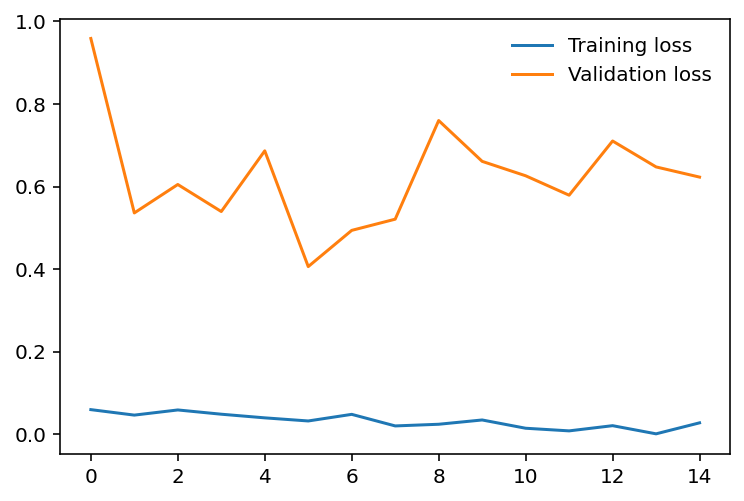

In [46]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

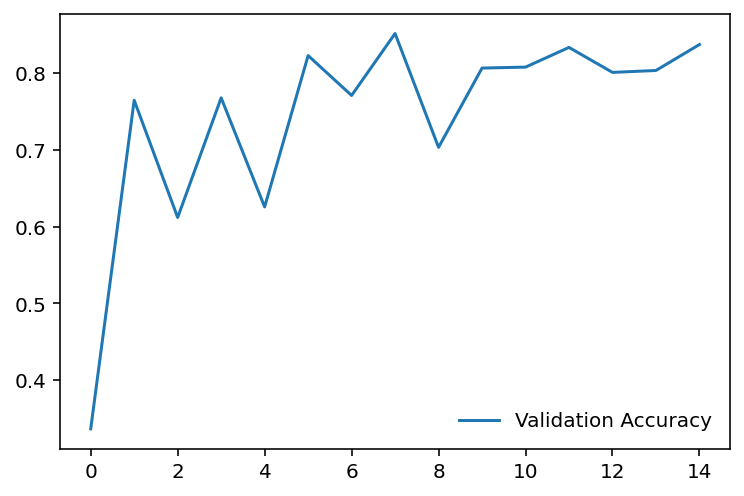

In [47]:
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend(frameon=False)

## **Model Evaluation**

In [65]:
model.eval() # Prep model for Evaluation

mean_of = 1 # Mean of how many evaluations
valid_loss = 0.0
class_correct = list(0. for i in range(len(classes))) # List of number of correct predictions in each class
class_total = list(0. for i in range(len(classes))) # List of total number of samples in each class

for i in range(mean_of):
  for data, target in valid_loader:
    # Move the data to device
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    # calculate test accuracy for each object class
    for i in range(len(target)):    
        label = target.data[i]
        if len(target) == 1:
          class_correct[label] += correct.item()
        else:
          class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print average test loss
valid_loss = valid_loss/(mean_of * len(valid_loader.dataset))
print('Test Loss: {:.6f}\n'.format(valid_loss))

# print accuracy of each class
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %0.2f%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
acc = 100. * np.sum(class_correct) / np.sum(class_total)

# print total accuracy of the model
print('\nTest Accuracy (Overall): %0.2f%% (%2d/%2d)' % (
    acc,
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.422263

Test Accuracy of     0: 74.25% (741/998)
Test Accuracy of     1: 94.99% (512/539)

Test Accuracy (Overall): 81.52% (1253/1537)
